# Train Classification Model for Car State Compomnents

## Set-up environment

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
from PIL import Image
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if device.type == 'cuda':
    print(f"Device name: {torch.cuda.get_device_name(0)}")

Using device: cuda
Device name: Tesla T4


In [2]:
from google.colab import drive


print("Mounting Google Drive...")
drive.mount('/content/drive')
print("Google Drive mounted successfully at /content/drive")

zip_file_path_in_drive = "/content/drive/MyDrive/ML/datasets/datasets-full.zip"

extraction_path_in_colab = "/content"

import os

# Check if the ZIP file exists
if not os.path.exists(zip_file_path_in_drive):
  print(f"ERROR: ZIP file not found at '{zip_file_path_in_drive}'. Please check the path and try again.")
else:
  print(f"ZIP file found: '{zip_file_path_in_drive}'")

# Create the extraction directory if it doesn't exist
if not os.path.exists(extraction_path_in_colab):
  os.makedirs(extraction_path_in_colab)
  print(f"Created extraction directory: '{extraction_path_in_colab}'")
else:
  print(f"Extraction directory already exists: '{extraction_path_in_colab}'")

#@title 3. Extract the ZIP File
import zipfile
import time

# Ensure the paths are set from the previous cell
if not 'zip_file_path_in_drive' in globals() or not os.path.exists(zip_file_path_in_drive):
  print("ERROR: ZIP file path is not correctly set or the file does not exist. Please run Step 2 first.")
elif not 'extraction_path_in_colab' in globals():
  print("ERROR: Extraction path is not correctly set. Please run Step 2 first.")
else:
  try:
    print(f"Starting extraction of '{zip_file_path_in_drive}' to '{extraction_path_in_colab}'...")
    start_time = time.time()

    # Open the ZIP file
    with zipfile.ZipFile(zip_file_path_in_drive, 'r') as zip_ref:
      zip_ref.extractall(extraction_path_in_colab)

    end_time = time.time()
    extraction_time = end_time - start_time
    print(f"Successfully extracted '{zip_file_path_in_drive}' to '{extraction_path_in_colab}'")
    print(f"Extraction took {extraction_time:.2f} seconds.")

  except zipfile.BadZipFile:
    print(f"ERROR: The file '{zip_file_path_in_drive}' is not a valid ZIP file or is corrupted.")
  except FileNotFoundError:
    print(f"ERROR: The ZIP file '{zip_file_path_in_drive}' was not found. Please ensure the path is correct.")
  except Exception as e:
    print(f"An unexpected error occurred during extraction: {e}")

Mounting Google Drive...
Mounted at /content/drive
Google Drive mounted successfully at /content/drive
ZIP file found: '/content/drive/MyDrive/ML/datasets/datasets-full.zip'
Extraction directory already exists: '/content'
Starting extraction of '/content/drive/MyDrive/ML/datasets/datasets-full.zip' to '/content'...
Successfully extracted '/content/drive/MyDrive/ML/datasets/datasets-full.zip' to '/content'
Extraction took 2.86 seconds.


# Train EfficientNet


## Dataset, Model, and Training Parameters

In [3]:
CSV_FILE_PATH = '/content/datasets/annotations.csv'
IMAGE_DIR_PATH = '/content/datasets'

# ---Model & Training Parameters---
IMG_HEIGHT = 320
IMG_WIDTH = 320
BATCH_SIZE = 32
NUM_EPOCHS = 100
LEARNING_RATE = 0.001
NUM_COMPONENTS = 5
VAL_SPLIT = 0.2

## Dataset Class Definition

In [4]:
class CarComponentsDataset(Dataset):
    def __init__(self, csv_file_path, image_dir_path, transform=None, file_column='filename', label_columns=None):
        try:
            self.annotations_df = pd.read_csv(csv_file_path)
        except FileNotFoundError:
            print(f"Error: The file {csv_file_path} was not found.")
            self.annotations_df = pd.DataFrame() # Empty dataframe
            return

        self.image_dir_path = image_dir_path
        self.transform = transform
        self.file_column = file_column

        if label_columns is None:
            self.label_columns = self.annotations_df.columns.tolist()[1:1+NUM_COMPONENTS]
        else:
            self.label_columns = label_columns

        print(f"Dataset initialized. Found {len(self.annotations_df)} entries.")
        print(f"Using image filenames from column: '{self.file_column}'")
        print(f"Using labels from columns: {self.label_columns}")


    def __len__(self):
        return len(self.annotations_df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        if idx >= len(self.annotations_df):
            raise IndexError("Index out of bounds")

        img_name = os.path.join(self.image_dir_path, self.annotations_df.iloc[idx][self.file_column])

        try:
            image = Image.open(img_name).convert('RGB')
        except FileNotFoundError:
            print(f"Warning: Image not found at {img_name}. Returning None.")
            return None, None # Or some placeholder

        labels = self.annotations_df.iloc[idx][self.label_columns].values.astype(np.float32)
        labels_tensor = torch.tensor(labels, dtype=torch.float32)

        if self.transform:
            image = self.transform(image)

        return image, labels_tensor



## Data Transformations


In [5]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'eval': transforms.Compose([
        transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
}

## Data Loading and Splitting

In [6]:

full_dataset = CarComponentsDataset(
    csv_file_path=CSV_FILE_PATH,
    image_dir_path=IMAGE_DIR_PATH,
    file_column= 'filename',
)

train_loader = None
eval_loader = None

if not full_dataset.annotations_df.empty:
    # Split dataset
    total_len = len(full_dataset)
    eval_len = int(VAL_SPLIT * total_len)
    train_len = total_len - eval_len

    print(f"Total dataset size: {total_len}")
    print(f"Training set size: {train_len}")
    print(f"Evaluation set size: {eval_len}")

    train_subset, eval_subset = random_split(full_dataset, [train_len, eval_len])

    class TransformedSubset(Dataset):
        def __init__(self, subset, transform):
            self.subset = subset
            self.transform = transform
        def __getitem__(self, index):
            x, y = self.subset[index]
            if x is None: # Handle cases where image loading failed
                return None, None
            if self.transform:
                x = self.transform(x)
            return x, y
        def __len__(self):
            return len(self.subset)

    train_dataset_transformed = TransformedSubset(train_subset, data_transforms['train'])
    eval_dataset_transformed = TransformedSubset(eval_subset, data_transforms['eval'])

    # Create DataLoaders
    train_loader = DataLoader(train_dataset_transformed, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
    eval_loader = DataLoader(eval_dataset_transformed, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

    print("DataLoaders created.")
else:
    print("Full dataset is empty. Cannot create DataLoaders. Please check CSV path and content.")

Dataset initialized. Found 2560 entries.
Using image filenames from column: 'filename'
Using labels from columns: ['front_left', 'front_right', 'rear_left', 'rear_right', 'hood']
Total dataset size: 2560
Training set size: 2048
Evaluation set size: 512
DataLoaders created.


## Load Model Architecture

In [7]:
model = models.efficientnet_b3(weights=None) # 'weights=None' means random initialization

num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, NUM_COMPONENTS)

model = model.to(device)

## Loss Function Metrics, Optimizer and Scheduler

In [8]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=0.01)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


## Training and Evaluation Functions


In [9]:
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct_component_predictions = 0
    total_component_predictions = 0

    for i, data in enumerate(dataloader):
        if data is None or data[0] is None: # Handle potential None from dataset
             print(f"Skipping batch {i+1} due to missing data.")
             continue
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs) # Raw logits
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

        # Calculate accuracy per component
        preds = torch.sigmoid(outputs) > 0.5 # Apply sigmoid and threshold
        total_component_predictions += labels.numel() # numel gives total number of elements (batch_size * num_components)
        correct_component_predictions += (preds == labels).sum().item()

    epoch_loss = running_loss / len(dataloader.dataset)
    # Accuracy here is the average accuracy across all components and all samples
    epoch_acc = 100.0 * correct_component_predictions / total_component_predictions if total_component_predictions > 0 else 0
    return epoch_loss, epoch_acc


def evaluate_model(model, dataloader, criterion, device):
    model.eval()  # Set model to evaluation mode
    running_loss = 0.0
    correct_component_predictions = 0
    total_component_predictions = 0

    with torch.no_grad():
        for data in dataloader:
            if data is None or data[0] is None: continue
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)

            preds = torch.sigmoid(outputs) > 0.5
            total_component_predictions += labels.numel()
            correct_component_predictions += (preds == labels).sum().item()

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = 100.0 * correct_component_predictions / total_component_predictions if total_component_predictions > 0 else 0
    return epoch_loss, epoch_acc

## Main Training Loop


In [10]:
history = {'train_loss': [], 'train_acc': [], 'eval_loss': [], 'eval_acc': []}
best_eval_loss = float('inf')

if train_loader is not None and eval_loader is not None:
    print(f"\n🔴 Starting Training using EfficientNet-B3 (Random Weights) on {device} 🔴")

    for epoch in range(NUM_EPOCHS):
        print(f"\n--- Epoch {epoch+1}/{NUM_EPOCHS} ---")
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
        print(f"Train Loss: {train_loss:.4f}, Train Component Acc: {train_acc:.2f}%")
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)

        eval_loss, eval_acc = evaluate_model(model, eval_loader, criterion, device)
        print(f"Eval Loss: {eval_loss:.4f}, Eval Component Acc: {eval_acc:.2f}%")
        history['eval_loss'].append(eval_loss)
        history['eval_acc'].append(eval_acc)

        scheduler.step(eval_loss) # Step the LR scheduler based on validation loss

        if eval_loss < best_eval_loss:
            best_eval_loss = eval_loss
            try:
                torch.save(model.state_dict(), '/content/drive/MyDrive/ML/efficientnet_b3_multilabel_best.pth')
                print(f"Saved best model weights at epoch {epoch+1} (Eval Loss: {best_eval_loss:.4f})")
            except Exception as e:
                print(f"Error saving model: {e}")


    print("\n--- Training Finished ---")
else:
    print("Training skipped because DataLoaders were not initialized (check CSV/image paths).")


🔴 Starting Training using EfficientNet-B3 (Random Weights) on cuda 🔴

--- Epoch 1/100 ---
Train Loss: 0.7127, Train Component Acc: 49.59%
Eval Loss: 0.6955, Eval Component Acc: 48.48%
Saved best model weights at epoch 1 (Eval Loss: 0.6955)

--- Epoch 2/100 ---
Train Loss: 0.6969, Train Component Acc: 50.83%
Eval Loss: 0.7638, Eval Component Acc: 49.80%

--- Epoch 3/100 ---
Train Loss: 0.6982, Train Component Acc: 49.13%
Eval Loss: 0.6929, Eval Component Acc: 50.74%
Saved best model weights at epoch 3 (Eval Loss: 0.6929)

--- Epoch 4/100 ---
Train Loss: 0.6945, Train Component Acc: 51.37%
Eval Loss: 0.6891, Eval Component Acc: 51.76%
Saved best model weights at epoch 4 (Eval Loss: 0.6891)

--- Epoch 5/100 ---
Train Loss: 0.6877, Train Component Acc: 54.57%
Eval Loss: 0.7011, Eval Component Acc: 55.35%

--- Epoch 6/100 ---
Train Loss: 0.6737, Train Component Acc: 57.14%
Eval Loss: 0.6729, Eval Component Acc: 57.30%
Saved best model weights at epoch 6 (Eval Loss: 0.6729)

--- Epoch 7/100

# Plot Model Performance

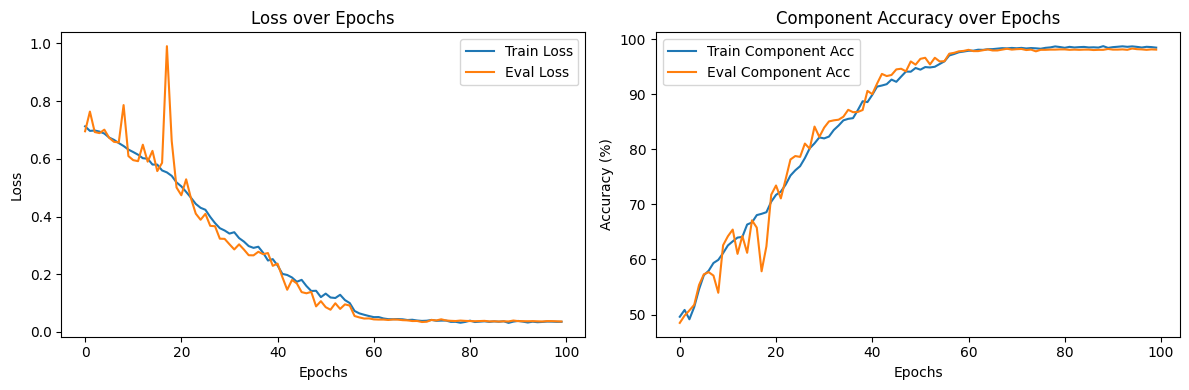

In [11]:
# Cell 10: Plot Training History
if train_loader is not None and eval_loader is not None:
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['eval_loss'], label='Eval Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train Component Acc')
    plt.plot(history['eval_acc'], label='Eval Component Acc')
    plt.title('Component Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.tight_layout()
    plt.show()